In [28]:
import random
from deap import base
from deap import creator
from deap import tools
from functools import partial
import numpy as np
import pickle
from deap import algorithms
import random
from datetime import datetime
import matplotlib.pyplot as plt


creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

In [29]:
def objective(individual, generation):
    return random.random()+individual[0],


def feasible(individual):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    return all(individual >0)

def distance(individual):
    """A distance function to the feasibility region."""
    return (individual[0] - 5.0)**2


In [53]:

#register individuals
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.90, 1.10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoints)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", objective)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, -100.0))


CXPB, MUTPB = .5,10.0


In [54]:

restart = False
restart_file = "ga_restart.pkl"
save_file = "ga_restart3.pkl"

In [55]:
#restart from file
if restart:
    with open(restart_file, "r") as cp_file:
        cp = pickle.load(cp_file)
    population = cp["population"]
    start_gen = cp["generation"]
    halloffame = cp["halloffame"]
    logbook = cp["logbook"]
    random.setstate(cp["rndstate"])
#fresh start
else:
    population = toolbox.population(n=100)
    start_gen = 0
    halloffame = tools.HallOfFame(maxsize=1, similar=np.array_equal)
    logbook = tools.Logbook()
    random.seed(datetime.now())

In [56]:
#register stats
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_ind = tools.Statistics(lambda ind: ind)
mstats = tools.MultiStatistics(fitness=stats_fit, individual=stats_ind)
mstats.register("avg", np.mean, axis=0)
mstats.register("std", np.std, axis=0)
mstats.register("min", np.min, axis=0)
mstats.register("max", np.max, axis=0)
mstats.register("size", np.size, axis=0)


In [57]:
FREQ=1
for gen in range(start_gen, start_gen+100):
    population = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(partial(toolbox.evaluate, generation=gen), invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    halloffame.update(population)
    record = mstats.compile(population)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)

    population = toolbox.select(population, k=len(population))
    if gen % FREQ == 0:
        # Fill the dictionary using the dict(key=value[, ...]) constructor
        cp = dict(population=population, generation=gen, halloffame=halloffame,
                  logbook=logbook, rndstate=random.getstate())

        with open(save_file, "wb") as cp_file:
            pickle.dump(cp, cp_file)



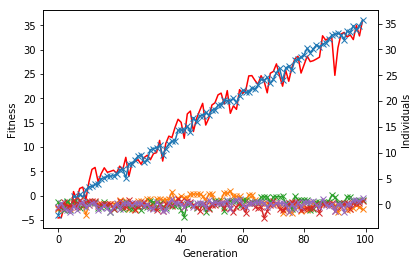

In [59]:
with open(save_file, "r") as cp_file:
    cp = pickle.load(cp_file)
population2 = cp["population"]
start_gen2 = cp["generation"]
halloffame2 = cp["halloffame"]
logbook2 = cp["logbook"]
random.setstate(cp["rndstate"])

gen2 = logbook2.select("gen")
fit_mins2 = logbook2.chapters["fitness"].select("avg")
size_avgs2 = logbook2.chapters["individual"].select("min")




fig, ax1 = plt.subplots()
line2 = ax1.plot(gen2, fit_mins2, "r-", label="Minimum Fitness")

ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")


# for tl in ax1.get_yticklabels():
#     tl.set_color("b")

ax2 = ax1.twinx()
line22 = ax2.plot(gen2, size_avgs2, marker='x', label="Average Size")

ax2.set_ylabel("Individuals")
# for tl in ax2.get_yticklabels():
#     tl.set_color("r")

# lns = line1 + line2
# labs = [l.get_label() for l in lns]
# ax1.legend(lns, labs, loc="center right")

plt.show()
